#0 Introduction

The goal of the project is to use GTZAN Dataset which containes short excerpts from song and then to predict the genre of a song given. We can also use the neural network to do some music recommandations.

https://www.kaggle.com/code/andradaolteanu/work-w-audio-data-visualise-classify-recommend#Machine-Learning-Classification


#1 Import Data

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip gdrive/MyDrive/datasets/music.zip

Archive:  gdrive/MyDrive/datasets/music.zip
  inflating: Data/features_30_sec.csv  
  inflating: Data/features_3_sec.csv  
  inflating: Data/genres_original/blues/blues.00000.wav  
  inflating: Data/genres_original/blues/blues.00001.wav  
  inflating: Data/genres_original/blues/blues.00002.wav  
  inflating: Data/genres_original/blues/blues.00003.wav  
  inflating: Data/genres_original/blues/blues.00004.wav  
  inflating: Data/genres_original/blues/blues.00005.wav  
  inflating: Data/genres_original/blues/blues.00006.wav  
  inflating: Data/genres_original/blues/blues.00007.wav  
  inflating: Data/genres_original/blues/blues.00008.wav  
  inflating: Data/genres_original/blues/blues.00009.wav  
  inflating: Data/genres_original/blues/blues.00010.wav  
  inflating: Data/genres_original/blues/blues.00011.wav  
  inflating: Data/genres_original/blues/blues.00012.wav  
  inflating: Data/genres_original/blues/blues.00013.wav  
  inflating: Data/genres_original/blues/blues.00014.wav  
  infla

In [ ]:
general_path = "/content/Data"
test_path= "/genres_original/rock/rock.00017.wav"

# 2 Exploring Data

The Data

- genres original - A collection of 10 genres with 100 audio files each, all having a length of 30 seconds (the famous GTZAN dataset, the MNIST of sounds) - ``'rock', 'classical', 'metal', 'disco', 'blues', 'reggae', 'country', 'hiphop', 'jazz', 'pop'``

- images original - A visual representation for each audio file.

- 2 CSV files - Containing features of the audio files.

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn


import librosa
import librosa.display
import IPython.display as ipd
import warnings
warnings.filterwarnings('ignore')

Before we do anything, it is important to understand what is an audio file to be able to extract important features for the neural network.

The goal is to use CNN to use the visual representation of the audio file to do predictions.

## Basic features of a file

In [ ]:
y, sr = librosa.load(f'{general_path}{test_path}')

print('y:', y, '\n')
print('y shape:', np.shape(y), '\n')
print('Sample Rate (KHz):', sr, '\n')

y: [-0.01455688 -0.06048584 -0.02310181 ...  0.15847778  0.17572021
  0.04360962] 

y shape: (661794,) 

Sample Rate (KHz): 22050 



## Extracting signal amplitude

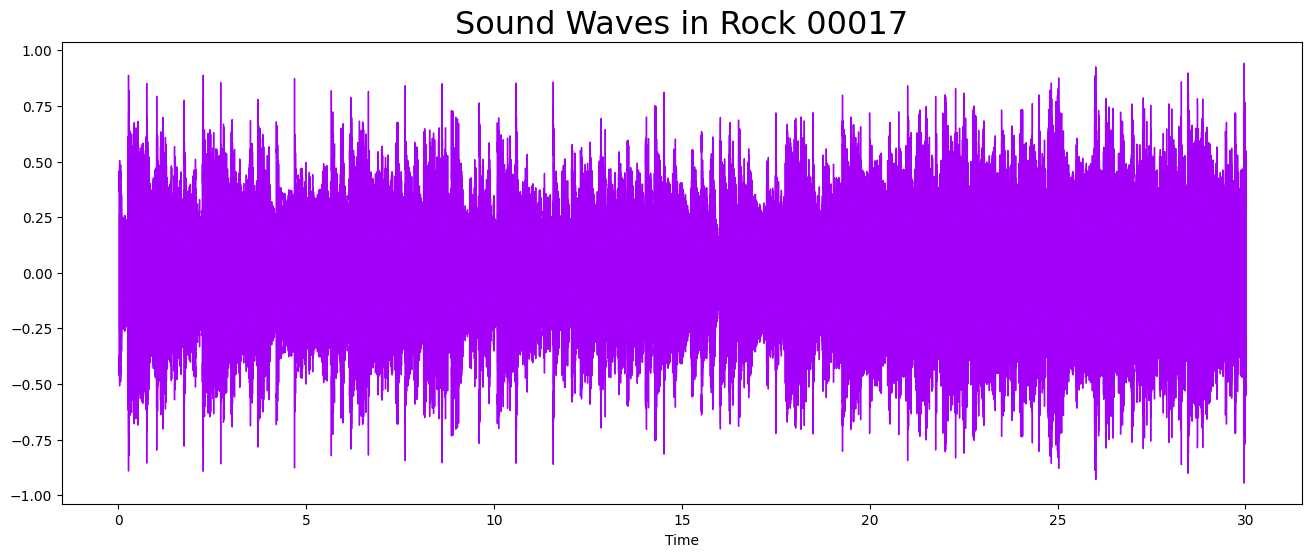

In [ ]:
audio_file = y

plt.figure(figsize = (16, 6))
librosa.display.waveshow(y = audio_file, sr = sr, color = "#A300F9");
plt.title("Sound Waves in Rock 00017", fontsize = 23);

Values on the Y axis vary between -1 and 1 indicate the intensity of the sound. Values closer to 1 or -1 mean the sound is louder (more sound energy at that moment).

Here we see that the sound is dense during all the 30s --> typical for a rock song

## Extract signal frequencies

We use a famous math tool called "Fourier Transform" to represent the audio file as a succesion of frequencies in Hertz.

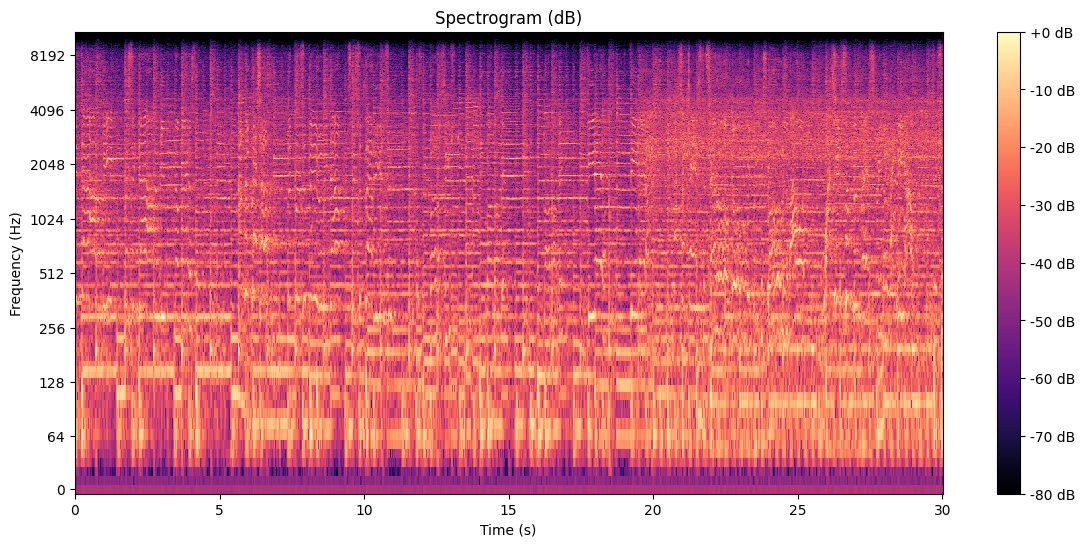

In [ ]:
D = librosa.stft(y)
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

plt.figure(figsize=(14, 6))
librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram (dB)')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.show()


## Mel Spectrogram

This is what is the exact same graph above but the value are scaled according to the "mel" scale.

The Mel Scale was developed to take this into account by conducting experiments with a large number of listeners. It is a scale of pitches, such that each unit is judged by listeners to be equal in pitch distance from the next.

![mel](https://lh3.googleusercontent.com/proxy/3VB9pOVL_ur3lqo5obJoHgugORLniXZcNMCcINSk6g-m8frQVcJh1mLUoitLmNxGSFquhU7DN1rdWZ2avJSwb1sFCP8)

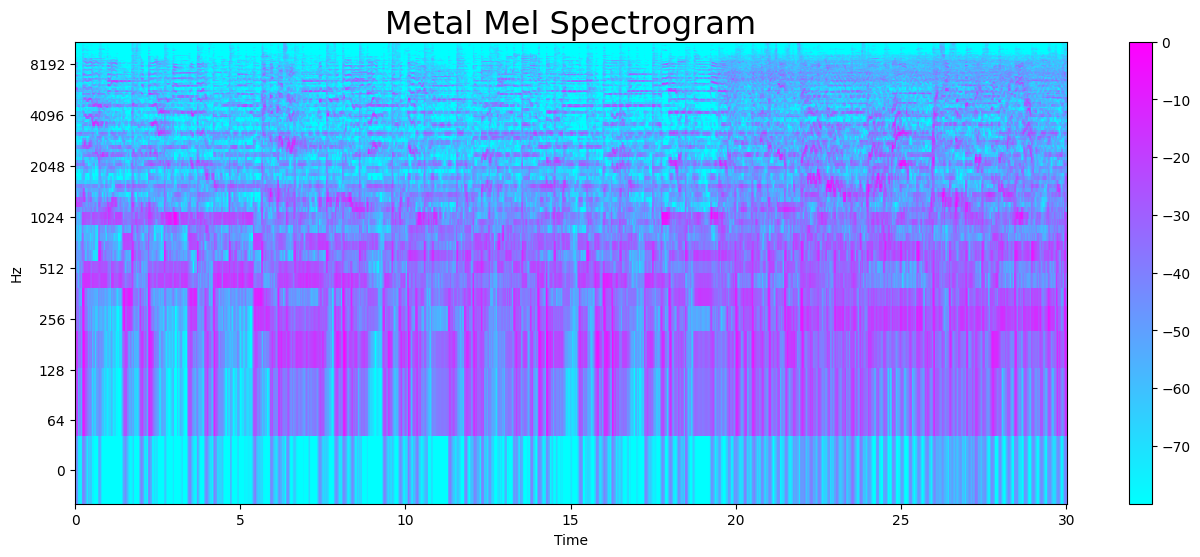

In [ ]:
y, sr = librosa.load(f'{general_path}{test_path}')
y, _ = librosa.effects.trim(y)


S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
S_DB = librosa.amplitude_to_db(S, ref=np.max)
plt.figure(figsize = (16, 6))
librosa.display.specshow(S_DB, sr=sr, hop_length=512, x_axis = 'time', y_axis = 'log',
                        cmap = 'cool');
plt.colorbar();
plt.title("Metal Mel Spectrogram", fontsize = 23);

Et puis il y a d'autres trucs, je sais pas si on va en parler, mais là il fait beau donc je sors dehors.

# 3. Implementing a CNN to do predictions

https://www.kaggle.com/code/dapy15/music-genre-classification

2 datasets:
- Use the features in the CSV file and use a gradient boosting to do predictions
- Use the provided images / compute the MEL spectogram for each picture and use a CNN to do predictions

Then we compare the results of both

## a) Load Images

In [ ]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

In [ ]:
width = 336
height = 218
batch_size = 64

img_path = "/content/Data/images_original"

In [ ]:
#Get the genres
genres = os.listdir(img_path)
genres

labels = {}
for i, genre in enumerate(genres):
  labels[i] = genre

labels

{0: 'disco',
 1: 'jazz',
 2: 'hiphop',
 3: 'country',
 4: 'reggae',
 5: 'blues',
 6: 'rock',
 7: 'classical',
 8: 'metal',
 9: 'pop'}

In [ ]:
X = []
y = []

for genre in genres:
    genre_path = os.path.join(img_path, genre)
    for filename in os.listdir(genre_path):
        if filename.endswith('.png'):
            file_path = os.path.join(genre_path, filename)
            # Charger l'image
            img = cv2.imread(file_path)
            # Redimensionner l'image
            img = img[35:253, 54:390]
            #img = cv2.resize(img, (width, height))
            # Normaliser l'image
            img = img / 255.0
            # Ajouter l'image et le label à la liste
            X.append(img)
            y.append(genres.index(genre))

X = np.array(X)
y = np.array(y)

In [ ]:
y = to_categorical(y, num_classes=len(genres))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f'Train data shape: {X_train.shape}')
print(f'Test data shape: {X_test.shape}')
print(f'Train labels shape: {y_train.shape}')
print(f'Test labels shape: {y_test.shape}')

Train data shape: (799, 218, 336, 3)
Test data shape: (200, 218, 336, 3)
Train labels shape: (799, 10)
Test labels shape: (200, 10)


In [ ]:
"""model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(height, width, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(genres), activation='softmax')
])

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(height, width, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    GlobalAveragePooling2D(),

    Dense(128, activation='relu'),
    Dropout(0.5),

    Dense(len(genres), activation='softmax')
])

# Compiler le modèle
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Vérifier la structure du modèle
model.summary()"""

"model = Sequential([\n    Conv2D(32, (3, 3), activation='relu', input_shape=(height, width, 3)),\n    MaxPooling2D((2, 2)),\n    Conv2D(64, (3, 3), activation='relu'),\n    MaxPooling2D((2, 2)),\n    Conv2D(128, (3, 3), activation='relu'),\n    MaxPooling2D((2, 2)),\n    Flatten(),\n    Dense(128, activation='relu'),\n    Dropout(0.5),\n    Dense(len(genres), activation='softmax')\n])\n\nfrom tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D\n\nmodel = Sequential([\n    Conv2D(32, (3, 3), activation='relu', input_shape=(height, width, 3)),\n    BatchNormalization(),\n    MaxPooling2D((2, 2)),\n\n    Conv2D(64, (3, 3), activation='relu'),\n    BatchNormalization(),\n    MaxPooling2D((2, 2)),\n\n    Conv2D(128, (3, 3), activation='relu'),\n    BatchNormalization(),\n    MaxPooling2D((2, 2)),\n\n    Conv2D(256, (3, 3), activation='relu'),\n    BatchNormalization(),\n    MaxPooling2D((2, 2)),\n\n    GlobalAveragePoolin

In [ ]:
"""from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# Charger le modèle VGG16 pré-entraîné sans les couches supérieures
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(height, width, 3))

# Ajouter des couches de classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(genre), activation='softmax')(x)

# Définir le modèle final
model = Model(inputs=base_model.input, outputs=predictions)

# Geler les couches de base
for layer in base_model.layers:
    layer.trainable = False

# Compilation du modèle
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Afficher le résumé du modèle
model.summary()
"""

"from tensorflow.keras.applications import VGG16\nfrom tensorflow.keras.models import Model\nfrom tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D\nfrom tensorflow.keras.optimizers import Adam\n\n# Charger le modèle VGG16 pré-entraîné sans les couches supérieures\nbase_model = VGG16(weights='imagenet', include_top=False, input_shape=(height, width, 3))\n\n# Ajouter des couches de classification\nx = base_model.output\nx = GlobalAveragePooling2D()(x)\nx = Dense(128, activation='relu')(x)\nx = Dropout(0.5)(x)\npredictions = Dense(len(genre), activation='softmax')(x)\n\n# Définir le modèle final\nmodel = Model(inputs=base_model.input, outputs=predictions)\n\n# Geler les couches de base\nfor layer in base_model.layers:\n    layer.trainable = False\n\n# Compilation du modèle\nmodel.compile(optimizer=Adam(learning_rate=0.001),\n              loss='categorical_crossentropy',\n              metrics=['accuracy'])\n\n# Afficher le résumé du modèle\nmodel.summary()\n"

In [ ]:
from tensorflow.keras.applications import VGG16

# Charger le modèle VGG16 pré-entraîné sans inclure les couches fully connected (weights='imagenet' utilise les poids pré-entraînés sur ImageNet)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(height, width, 3))

# Congeler les couches du modèle de base (ne pas entraîner ces couches lors de l'entraînement du modèle)
base_model.trainable = False

# Créer votre modèle en ajoutant des couches au-dessus du modèle de base
model = Sequential([
    base_model,  # Ajouter le modèle VGG16 comme une couche dans le modèle séquentiel
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(genres), activation='softmax')
])

# Compiler le modèle
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Vérifier la structure du modèle
model.summary()

# Entraîner le modèle
hist = model.fit(X_train, y_train,
                 validation_data=(X_test, y_test),
                 epochs=40,
                 batch_size=64)


58889256/58889256 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 6, 10, 512)        14714688  
                                                                 
 flatten (Flatten)           (None, 30720)             0         
                                                                 
 dense (Dense)               (None, 128)               3932288   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 18648266 (71.14 MB)
Trainable params: 3933578 (15.01 MB)
Non-trainable params: 14714688 (56.13 MB)
__________

In [ ]:
"""hist = model.fit(X_train, y_train,
                 validation_data = (X_test, y_test),
                 epochs = 40,
                 batch_size = 64)"""

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


def plot_training_curves(history):
    loss= np.array(history.history['loss'])
    val_loss= np.array(history.history['val_loss'])

    accuracy= np.array(history.history['accuracy'])
    val_accuracy= np.array(history.history['val_accuracy'])

    epochs= range(len(history.history['loss']))

    fig, (ax1, ax2)= plt.subplots(1,2,figsize=(10,3))

    #plot loss
    ax1.plot(epochs, loss, label='traing_loss', marker='o')

    ax1.plot(epochs, val_loss, label='val_loss', marker='o')

    ax1.fill_between(epochs,loss, val_loss, where=(loss>val_loss),color='C0',alpha=0.3,interpolate=True)
    ax1.fill_between(epochs,loss, val_loss, where=(loss<val_loss),color='C1',alpha=0.3,interpolate=True)

    ax1.set_title('Loss(Lower Means Better)',fontsize= 16)
    ax1.set_xlabel('Epochs', fontsize=10)

    ax1.legend()

    #plot Accuracy
    ax2.plot(epochs, accuracy, label='traing_accuracy', marker='o')

    ax2.plot(epochs, val_accuracy, label='val_accuracy', marker='o')

    ax2.fill_between(epochs,accuracy, val_accuracy, where=(accuracy>val_accuracy),color='C0',alpha=0.3,interpolate=True)
    ax2.fill_between(epochs,accuracy, val_accuracy, where=(accuracy<val_accuracy),color='C1',alpha=0.3,interpolate=True)

    ax2.set_title('Accuracy(Higher Means Better)',fontsize= 16)
    ax2.set_xlabel('Epochs', fontsize=10)

    ax2.legend()

plot_training_curves(hist)

# 4. Creating  a"similar music" generator

Using the cosine_similarity matrix

In [ ]:
# Libraries
import IPython.display as ipd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn import preprocessing

# Read data
data = pd.read_csv(f'{general_path}/features_30_sec.csv', index_col='filename')

# Extract labels
labels = data[['label']]

# Drop labels from original dataframe
data = data.drop(columns=['length','label'])
data.head()

# Scale the data
data_scaled=preprocessing.scale(data)
print('Scaled data type:', type(data_scaled))

In [ ]:
# Cosine similarity
similarity = cosine_similarity(data_scaled)
print("Similarity shape:", similarity.shape)

# Convert into a dataframe and then set the row index and column names as labels
sim_df_labels = pd.DataFrame(similarity)
sim_df_names = sim_df_labels.set_index(labels.index)
sim_df_names.columns = labels.index

sim_df_names.head()

In [ ]:
def find_similar_songs(name):
    series = sim_df_names[name].sort_values(ascending = False)
    series = series.drop(name)
    return series

In [ ]:
song = "pop.00019.wav"
style = song.split(".")[0]

similar = find_similar_songs(song)
similar_song_names = similar.index.tolist()

song2 = similar_song_names[0]
style2 = song2.split(".")[0]

song2

In [ ]:
ipd.Audio(f'{general_path}/genres_original/{style}/{song}')

In [ ]:
ipd.Audio(f'{general_path}/genres_original/{style2}/{song2}')